<a href="https://colab.research.google.com/github/miller00315/ia_studies/blob/main/transfer_learning_in_tensor_flow_part_2_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer learning with TensorFlow Part 2 fine tuning

In the previous notebook, we coovered transfer learning feature extraction, now it's time to learn about a new kind of transfer learning called fine tuning.

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
# Chkc if you are using a gpu

!nvidia-smi

Thu May 23 00:05:16 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   38C    P8              12W /  72W |      1MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Creating helper functions

In previous notebook, we've created a bunch of helper functions, now we could rewrite them all, however, this is tedious.

So it's a good idea to put functions you'll want to use again in a script you can download and import into your noteboks (or elsewhere).

We've done this for some of the functions we've used previously here: [herlper functions](https://raw.githubusercontent.com/miller00315/tensorflow-deep-learning/main/extras/helper_functions.py)

In [5]:
!wget https://raw.githubusercontent.com/miller00315/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-05-23 00:11:30--  https://raw.githubusercontent.com/miller00315/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0.001s  

2024-05-23 00:11:30 (15.4 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [6]:
# import helper function we're going to use in this notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

> 🔑 **Note:** If you're runnign this notebook in Google Colab , when it times out collab will delete `helper_functions.py`, so you'll have to redownload it if you want to your helper functions.

## Let's get some data

This time we're going to see how we can use the pretained models with tf.keras.application and apply then to our own problem.

In [7]:
# Get 10% of trained data of 10 classes of food

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2024-05-23 00:20:16--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.207, 74.125.137.207, 142.250.101.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   140MB/s    in 1.1s    

2024-05-23 00:20:18 (140 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [9]:
# Check out how many images and subdirectories are in our dat set
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/c

In [10]:
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [14]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                            label_mode="categorical",
                                                                            image_size=IMAGE_SIZE,
                                                                            batch_size=BATCH_SIZE
                                                                            )
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMAGE_SIZE,
                                                                batch_size=BATCH_SIZE
                                                                )

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [15]:
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [16]:
test_data.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [17]:
train_data_10_percent

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [ ]:
#See a example of batch data

for images, labels in  train_data_10_percent.take(1):
  print(images, labels)

In [22]:
input_shape = (224, 224, 3)

## Model 0: Building a transfer training model using the Keras Functional API

The sequential API is straight-forward, it runs our layers in sequential order.

But the functional API gives us more flexibility with our models. [Keras functional](https://www.tensorflow.org/guide/keras/functional_api)

In [25]:
# 1. Create the base model tf.keras.applications
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)

In [26]:
# 2. Freeze ther basemodel (sot the underlaying pre-trained patterns aren't updated during training)

base_model.trainable = False

In [27]:
# 3. Create inputs into our model

inputs = tf.keras.layers.Input(shape=IMAGE_SIZE + (3,), name="input_layer")

In [ ]:
# 4. If using ResNet50v2 you will need to normalize inputs (yout don't need have for EfficienteNet1)

#x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

In [28]:
# 5. Pass the inputs ro the base model
x = base_model(inputs)

print(f"Shape after passing through base model: {x.shape}")

Shape after passing through base model: (None, 7, 7, 1280)


In [29]:
# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

Shape after GlobalAveragePooling2D: (None, 1280)


In [30]:
# 7. Create the output activation layer

outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

In [31]:
# 8. Combine the inputs with the outputs in to a model

model_0 = tf.keras.Model(inputs, outputs)

In [32]:
# 9. Compile the model

model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [33]:
# 10. Fit the model and save its history

history_0 = model_0.fit(train_data_10_percent,
                        epochs=5,
                        steps_per_epoch=len(train_data_10_percent),
                        validation_data=test_data,
                        validation_steps=int(0.25 * len(test_data)),
                        callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_feature_extraction")])

Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20240523-013117
Epoch 1/5
24/24 [==============================] - 14s 137ms/step - loss: 1.9509 - accuracy: 0.3813 - val_loss: 1.3991 - val_accuracy: 0.6974
Epoch 2/5
24/24 [==============================] - 1s 46ms/step - loss: 1.1794 - accuracy: 0.7307 - val_loss: 0.9466 - val_accuracy: 0.8125
Epoch 3/5
24/24 [==============================] - 1s 47ms/step - loss: 0.8555 - accuracy: 0.8160 - val_loss: 0.7662 - val_accuracy: 0.8289
Epoch 4/5
24/24 [==============================] - 1s 46ms/step - loss: 0.7218 - accuracy: 0.8507 - val_loss: 0.6499 - val_accuracy: 0.8454
Epoch 5/5
24/24 [==============================] - 1s 46ms/step - loss: 0.6032 - accuracy: 0.8667 - val_loss: 0.5943 - val_accuracy: 0.8470


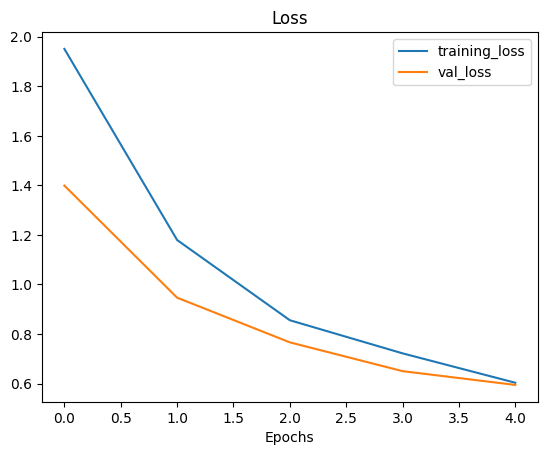

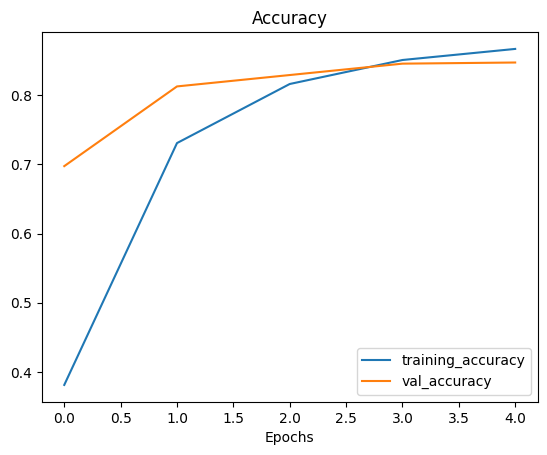

In [34]:
plot_loss_curves(history_0)

In [35]:
model_0.evaluate(test_data)

79/79 [==============================] - 2s 27ms/step - loss: 0.5815 - accuracy: 0.8568


[0.5815184712409973, 0.8568000197410583]

In [36]:
# Check the layer in our basemodel
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_4
1 rescaling_4
2 normalization_3
3 stem_conv
4 stem_bn
5 stem_activation
6 block1a_project_conv
7 block1a_project_bn
8 block1a_project_activation
9 block2a_expand_conv
10 block2a_expand_bn
11 block2a_expand_activation
12 block2a_project_conv
13 block2a_project_bn
14 block2b_expand_conv
15 block2b_expand_bn
16 block2b_expand_activation
17 block2b_project_conv
18 block2b_project_bn
19 block2b_drop
20 block2b_add
21 block3a_expand_conv
22 block3a_expand_bn
23 block3a_expand_activation
24 block3a_project_conv
25 block3a_project_bn
26 block3b_expand_conv
27 block3b_expand_bn
28 block3b_expand_activation
29 block3b_project_conv
30 block3b_project_bn
31 block3b_drop
32 block3b_add
33 block4a_expand_conv
34 block4a_expand_bn
35 block4a_expand_activation
36 block4a_dwconv2
37 block4a_bn
38 block4a_activation
39 block4a_se_squeeze
40 block4a_se_reshape
41 block4a_se_reduce
42 block4a_se_expand
43 block4a_se_excite
44 block4a_project_conv
45 block4a_project_bn
46 block4b_expand_conv
47 b

In [37]:
# How about we get a summary of the base model

base_model.summary()

Model: "efficientnetv2-b0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 rescaling_4 (Rescaling)     (None, None, None, 3)        0         ['input_4[0][0]']             
                                                                                                  
 normalization_3 (Normaliza  (None, None, None, 3)        0         ['rescaling_4[0][0]']         
 tion)                                                                                            
                                                                                                  
 stem_conv (Conv2D)          (None, None, None, 32)       864       ['normalizatio

In [38]:
# How about a summary of our whole model?

model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 5932122 (22.63 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 5919312 (22.58 MB)
__________________

## Getting a feature vecture froma trained model

Let's demostrate the Global Average Pooling 2D layer...

We have a tensor after our model goes through `base_model` of shape (None, None, None , 1280)

But when it passes through GlobalAveragePolling2D, it turns int (None, 1280)

Let's user a similar shaped shape tensor of (1, 4,4,3) anf then pass it to GlobalAveragePooling2D.

In [39]:
# Define the input shape

input_shape = (1, 4, 4, 3)

# Create a random tensor

tf.random.set_seed(42)

random_tensor = tf.random.normal(input_shape)

print(f"Random tensor:\n {random_tensor}\n")

# Average pool the random tensor

pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(random_tensor)

print(f"Pooled tensor:\n {pooled_tensor}")

Random tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338894  0.97772694]
   [ 0.24694404  0.20573746 -0.52562326]
   [ 0.32410017  0.02545409 -0.10638496]
   [-0.63694745  1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815628  0.23479679 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

Pooled tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]


In [40]:
# Check the shape of the diferent tensors

print(f"Random tensor shape: {random_tensor.shape}")
print(f"Pooled tensor shape: {pooled_tensor.shape}")

Random tensor shape: (1, 4, 4, 3)
Pooled tensor shape: (1, 3)


In [41]:
# Let's replicate the Global average pool 2D layer

tf.reduce_mean(random_tensor, axis=[1, 2])


<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

⚒  **Practice: ** Try to do the same with the above cells but this time use `GlobalMaxPool2D`... and see whats happens.

> 🔑 **Note: ** One of the reasons "features extraction transfer learning" is named how it is is beacause what often happens is pretrained model outputs a ** feature vector ** (a long tensor of numbers which represents the learned representation of the model on a particular sample, in our case, this is the output of the `tf.keras.layers.GlobalAveragePolling2D()` layer) which can then be used to extract patterns out of our own specfic problem.

In [42]:
y = tf.keras.layers.GlobalMaxPool2D()(random_tensor)
y

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[0.9058464, 1.1603122, 1.6994323]], dtype=float32)>